In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

## 1. Getting data for the Model

In [2]:
def get_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    y_train = AirPassengersPanel[
        AirPassengersPanel.ds < AirPassengersPanel['ds'].values[-12]]
    y_test = AirPassengersPanel[
        AirPassengersPanel.ds >= AirPassengersPanel['ds'].values[-12]
    ].reset_index(drop=True)
    return y_train, y_test

In [3]:
y_train, y_test = get_data()

In [4]:
y_train.head()

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0


In [5]:
y_train.tail()

,unique_id,ds,y,trend,y_[lag12]
271,Airline2,1959-08-31,859.0,271,805.0
272,Airline2,1959-09-30,763.0,272,704.0
273,Airline2,1959-10-31,707.0,273,659.0
274,Airline2,1959-11-30,662.0,274,610.0
275,Airline2,1959-12-31,705.0,275,637.0


## 2. Creating NBEATSx model object

Select arguments to NBEATSx that are passed explicitly:
1. *h* - horizon of the forecast
2. *input_size* - autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2]
3. *stat_exog_list*: str list, static exogenous columns.
4. *hist_exog_list*: str list, historic exogenous columns.
5. *futr_exog_list*: str list, future exogenous columns.
6. *exclude_insample_y*: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>

Select default arguments used under the hood:
1. *n_blocks*: list = [1, 1, 1] - Number of blocks for each stack
2. *mlp_units*: list = 3 * [[512, 512]] -
3. *n_harmonics*: int, Number of harmonic oscillations in the SeasonalityBasis [cos(i * t/n_harmonics), sin(i * t/n_harmonics)]. Note that it will only be used if 'seasonality' is in *stack_types*
4. *stack_types*: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity']
5.  *n_polynomials*: int, Number of polynomial terms for TrendBasis [1,t,...,t^n_poly]. Note that it will only be used if 'trend' is in *stack_types*


In the case at hand the model consists of three stacks. Each stack is made up from one block.

In [6]:
model = NBEATSx(
    h=12,
    input_size=24,
    loss=DistributionLoss(distribution='Normal', level=[80, 90]),
    scaler_type='robust',
    dropout_prob_theta=0.5,
    stat_exog_list=['airline1'],
    futr_exog_list=['trend'],
    max_steps=200,
    val_check_steps=10,
    early_stop_patience_steps=2
)
nf = NeuralForecast(models=[model], freq='M')

Seed set to 1


In [7]:
nf.fit(df=y_train, static_df=AirPassengersStatic, val_size=12)
y_hat = nf.predict(futr_df=y_test)

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

## 3. Calculating and plotting predictions

In [8]:
y_hat = y_hat.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([y_test, y_hat], axis=1)
plot_df = pd.concat([y_train, plot_df])
plot_df = (plot_df[plot_df.unique_id == 'Airline1'].
           drop('unique_id', axis=1))

In [9]:
# predictions
plot_df.loc[~plot_df.NBEATSx.isna(), :]

,ds,y,trend,y_[lag12],NBEATSx,NBEATSx-median,NBEATSx-lo-90,NBEATSx-lo-80,NBEATSx-hi-80,NBEATSx-hi-90
0,1960-01-31,417.0,132,360.0,415.180328,439.826233,417.560455,431.613068,420.484955,406.276978
1,1960-02-29,391.0,133,342.0,406.177124,408.797241,388.639252,414.537872,401.283691,362.640747
2,1960-03-31,419.0,134,406.0,457.825439,478.432556,443.210938,461.216187,451.842224,473.989044
3,1960-04-30,461.0,135,396.0,438.114716,437.983948,416.386169,432.132141,418.048431,420.262085
4,1960-05-31,472.0,136,420.0,464.254883,446.353760,469.824646,465.583801,469.381226,466.009796
5,1960-06-30,535.0,137,472.0,539.905334,522.090149,547.111450,552.045410,501.141266,546.802307
6,1960-07-31,622.0,138,548.0,613.420044,657.793518,641.052673,601.260010,516.375732,639.511658
7,1960-08-31,606.0,139,559.0,612.567261,645.543335,574.365417,612.094849,586.091553,641.438721
8,1960-09-30,508.0,140,463.0,534.710266,530.256592,522.534485,450.941559,583.822876,538.184326
9,1960-10-31,461.0,141,407.0,441.482605,413.930206,469.892273,477.320740,435.156616,426.532410


[]

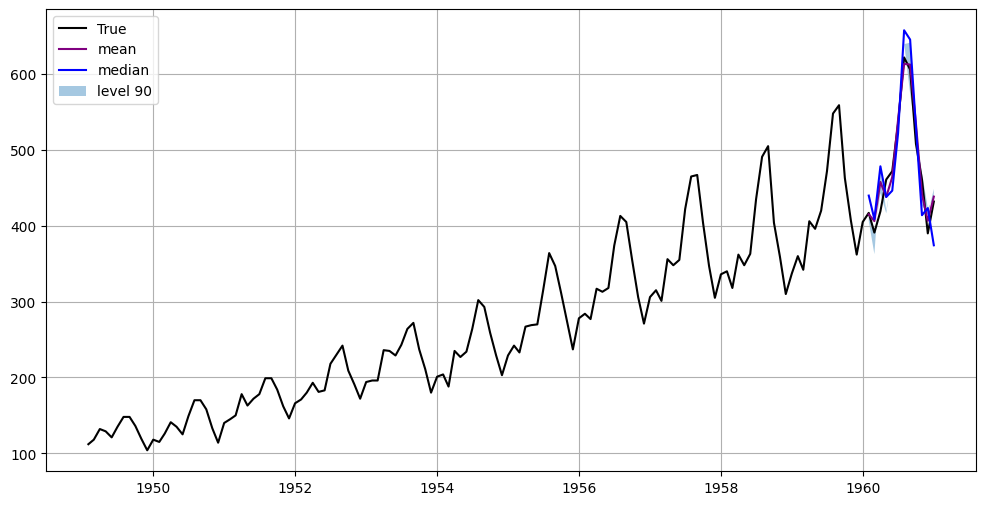

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATSx'], c='purple', label='mean')
plt.plot(
    plot_df['ds'], plot_df['NBEATSx-median'], c='blue', label='median')
plt.fill_between(
    x=plot_df['ds'][-12:],
    y1=plot_df['NBEATSx-lo-90'][-12:].values,
    y2=plot_df['NBEATSx-hi-90'][-12:].values,
    alpha=0.4, label='level 90'
)
plt.legend()
plt.grid()
plt.plot()